# Point Spread Function and StarFinder


경기과학고등학교 관측천문학 강좌를 위해 만들었으며  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>



# Atmospheric problems

지상에서 관측을 할 경우 대기에 의한 발생하는 문제를 해결해야 한다. 대기에 의해 나타나는 주된 효과는 다음 두가지 이다.

* Seeing
* Extinction (= scattering + absorption) : 이 강좌에서는 다루지 않을 예정임.

instrumental magnitude 를 구한 후에 "real" magnitude 를 얻는 과정을 **standardization** 이라고 하는데, 이 과정에서 *Extinction* 을 보정해 주어야 한다. 


## 1. Seeing

Seeing 이란, 망원경으로 별 등의 천체의 상을 보았을 때, 지구대기의 흔들림이나 망원경 내부의 공기의 흔들림에 의해 상이 흐려지거나 불규칙하게 변동하는 것을 말한다. 보통 5단계에서 10단계에 걸쳐 등급을 매긴다. 별이 점상으로 정지해 있을 때를 가장 좋은상태 5 또는 10으로 하고, 별과 배경의 구별이 되지 않는 가장 나쁜 상태를 1로 기입한다. [네이버 지식백과](https://terms.naver.com/entry.nhn?docId=1621937&cid=42469&categoryId=42469). seeing 에 대한 자세한 정보는  [여기](https://en.wikipedia.org/wiki/Seeing) 를 참고한다. 

별을 point source라 가정하면 seeing 때문에 CCD에 담긴 별은 부드럽게 퍼져 보인는데 이 모양은 **point spread function** 을 따르며 줄여서  **psf**.라고 한다.

널리 사용되는 점퍼짐 함수로 [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function) 과 [Moffat](https://en.wikipedia.org/wiki/Moffat_distribution). 두 가지가 있다. 

psf에서 사용되는 parameter 중에서 널리 사용되는 것이 FWHM (full width at half-maximum)이다. FWHM은 $\frac{1}{2} f_{\rm max}$ 이 되는 두점 사이의 거리로 정의된다. 

### 1.1. Gauss

원형으로 대칭인 Gauss psf 는 다음과 같다. 

$$ f_{\rm Gauss}(r) = A e^{ -(r-r_0)^2/2\sigma^2 } $$

Here, $r$ is the distance from the center, $r_0$, and $\sigma$ is the standard deviation of the profile. The normalization constant $A = \frac{1}{\sqrt{2 \pi \sigma^2}}$, such that the integration $ \int_{-\infty}^{+\infty} f_{\rm Gauss}(r) dr = 1$. 

The FWHM is calculated by setting $f_{\rm Gauss}(r_{1/2}) = \frac{A}{2}$. First we obtain

$$ (r_{1/2} - r_0)^2 = 2 \sigma^2 \log_e 2 $$

and thus

$$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 \sigma \sqrt{2 \log_e 2}  ~.$$


### 1.2. Moffat

원형으로 대칭인 Moffat psf 는 다음과 같다. 

$$f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta} ~.$$

Here, $r$ is the distance from the center, $r_0$, as in Gauss psf. By integration, I obtained the normalization constant $ A = \frac{\Gamma(\beta)}{R\sqrt{\pi} \Gamma(\beta-\frac{1}{2})} $. The parameter $R$ is called the core width and $\beta$ is called the power. In [astropy Moffat 2D](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat2D.html#astropy.modeling.functional_models.Moffat2D), `gamma` is used for the core width ($R$), and `alpha` is used for the power ($\beta$), which might be confusing. [IRAF Moffat 2D](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psfmeasure) uses `alpha` as the core width ($R$) and `beta` for the power ($\beta$), which has been a more standard notation in astronomy. Moffat considered atmospheric turbulence, instrumental abberation, and photographic receiver when he first instroduced this profile.

The FWHM is calculated by setting $f_{\rm Moffat}(r_{1/2}) = \frac{A}{2}$. As we did in Gauss example, we obtain

$$ (r_{1/2} - r_0)^2 = R^2 (2^{1/\beta}-1) $$

and thus

$$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 R \sqrt{2^{1/\beta}-1} ~.$$


### 1.3. Comparison (Gauss VS Moffat)

In uniform atmospheric seeing condition and long exposure time, psf should converge to a symmetric shape, i.e., isophotal curves should look like a concentric circles. It actually is rarely the case. We encounter elliptical, or even irregularly shaped isophotes. In such cases, you may make elliptical model rotated by certain angle, or simulate the seeing. Those fitting or simulation can be done using Astropy if necessary. Usually we believe the tracking is perfect, and use circular aperture. 

In the following example, I will show you the difference between Gaussian and Moffat in 1-D simple case.

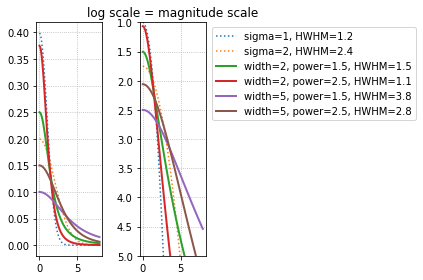

In [8]:
from astropy.modeling.functional_models import Moffat1D, Gaussian1D
from scipy.special import gamma as G
import numpy as np
from matplotlib import pyplot as plt

def norm_gauss(sigma):
    return 1/np.sqrt(2 * np.pi * sigma**2)

def norm_moffat(width, power):
    return G(power) / (width * np.sqrt(np.pi) * G(power - 1/2))

def HWHM_moffat(width, power):
    return width * np.sqrt( 2**(1/power) - 1)

x       = np.arange(0,8,0.1)
sigma   = np.array([1, 2])
width   = np.array([2, 5])
power   = np.array([1.5, 2.5])


ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for s in sigma:
    gauss  = Gaussian1D(amplitude=1, mean=0, stddev=s)    
    ax1.plot(x, norm_gauss(s)*gauss(x), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))
    ax2.plot(x, -2.5 * np.log10(norm_gauss(s)*gauss(x)), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))

for w in width:
    for p in power:
        moffat = Moffat1D(amplitude=1, x_0=0, gamma=w, alpha=p)
        HWHM   = HWHM_moffat(w, p)
        ax1.plot(x, norm_moffat(w, p) * moffat(x), lw=2,
                 label='w={0:.0f}, p={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))
        ax2.plot(x, -2.5*np.log10(norm_moffat(w, p) * moffat(x)), lw=2,
                 label='width={0:.0f}, power={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))

ax1.grid(ls=":")
ax2.grid(ls=":")
ax2.set_ylim(1, 5)
ax2.invert_yaxis()
ax2.set_title('log scale = magnitude scale')
plt.legend(bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

# Starfinder

photutils을 사용하여 편리하게 psf를 이용하여 편리하게 stars 를 identify 해 보자. 만약 아직 photutils 가 설치되지 않았다면 'anaconda prompt'에서 다음과 같이 입력하여 설치한다.

>conda install -c astropy photutils

이제 preprocessing 이 완료된 [example file](https://drive.google.com/file/d/154vZIQRABEujYlFGBASl7-ePrduS7FrO/view?usp=sharing) 을 다운로드 받아서 display 해 보자.

photoutils 에서는 ADU 값을 float 로 변환하여 처리하고 있음에 유의한다.


DELMAG   =   0.0000            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


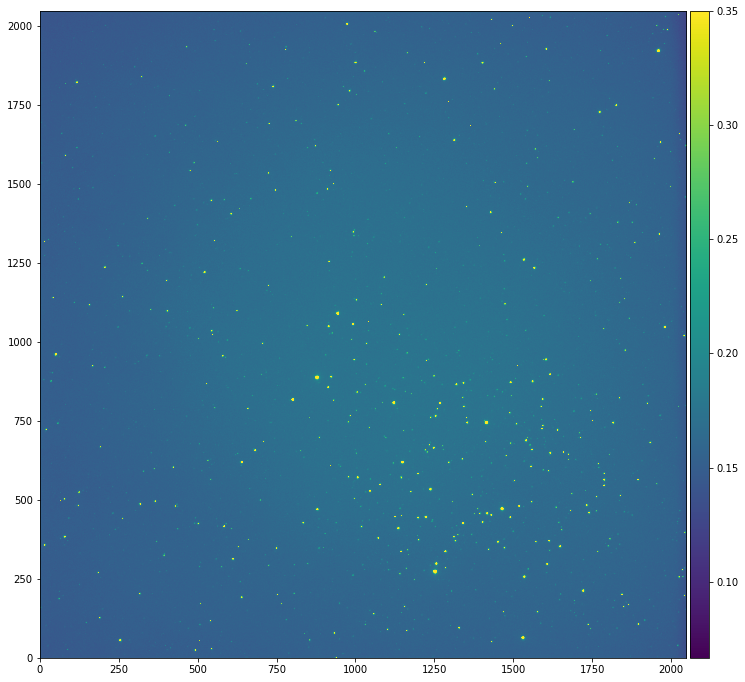

In [2]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
#%%
dir_name = '20170220_m35/'
f_name = 'g3035794_p.fits'

hdu = fits.open(dir_name+f_name)
img = np.array(hdu[0].data/65536, dtype=np.float32)

plt.figure(figsize=(12,12))
ax = plt.gca()
im = plt.imshow(img, vmax=0.35, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

별이 많이 보이는 일부만 잘라서 display 해 보자.

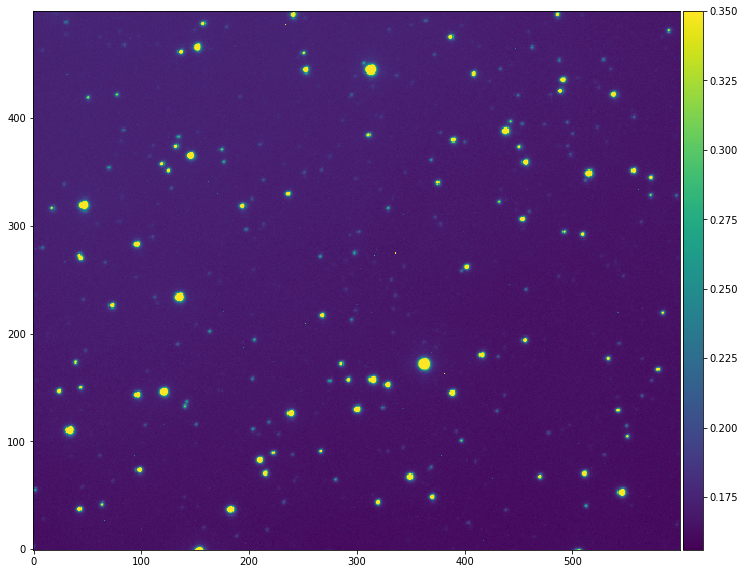

In [3]:
#%%
img = np.array(hdu[0].data[300:800, 1100:1700]/65536.0, dtype=np.float32)
#img = hdu[0].data
plt.figure(figsize=(12,12))
ax = plt.gca()
im = plt.imshow(img, vmax=0.35, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

Maxim DL 을 이용하여 FWHM 을 구해보니 약 2.7 pixels 였다. 

[MAD method](http://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html)를 이용하여 detection threshold 값을 결정해 보자. 또한 simga-clip (3-sigma, 5 iters)의 방법으로도 결정해 보자. 

In [4]:
#%%
from astropy.stats import mad_std, sigma_clipped_stats

FWHM   = 2.7
sky_th = 10    # sky_th * sky_sigma will be used for detection lower limit : sky_th = 5
sky_s  = mad_std(img)
thresh = sky_th*sky_s
print('sky_s x sky_th = threshold')
print('{0:8.6f} x {1:4d}   =   {2:8.6f}\n'.format(sky_s, sky_th, thresh))

# What if we do "sigma-clip" than MAD?
sky_a, sky_m, sky_s_sc = sigma_clipped_stats(img) # default is 3-sigma, 5 iters
thresh_sc = sky_th*sky_s_sc
thresh = sky_th*sky_s_sc
print('3 sigma 5 iters clipped case:')
print('{0:8.6f} x {1:4d}   =   {2:8.6f}\n'.format(sky_s_sc, sky_th, thresh_sc))


sky_s x sky_th = threshold
0.005067 x   10   =   0.050675

3 sigma 5 iters clipped case:
0.004250 x   10   =   0.042505



detection threshold는 다음의 코드를 통해 쉽게 얻을 수도 있다.


In [5]:
#%%
from photutils import detect_threshold

thresh_snr = detect_threshold(data=img.data, snr=3)
thresh_snr = thresh_snr[0][0]
# This will give you 3*bkg_std.
print('detect_threshold', thresh_snr)

detect_threshold 0.18200383


# DAOStarFinder

이제 fits file에서 starfinding 을 해 보자. 

DAOStarFinder에 대한 내용은 [photutils documentation](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder)에 잘 요약되어 있으므로 이를 참고한다. 

sharpness 와 roundness parameters 에 대한 정보는  [source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/detection/findstars.html)를 참고한다.

`DAOFIND`의 `GROUND` parameter인 `g_roundness` or `roundness1`를 찾고, `DAOFIND`의 `SROUND` 를 위해 `roundness1`를 찾는다.

감지 된 별들의 X, Y coordinate를 얻을 수 있다. astropy table object가 익숙하지 않은 경우에는 

>imgXY = np.array(coord)

numpy 형식으로 coordinate를 저장해 두면 편리하고, 결과를 바로 csv 파일로 저장해 둘 수도 있다. 

저장된 coordinate 는 후에 apature photometry routine 에 사용할 수 있다. 


149 stars were founded
 id     xcentroid          ycentroid           sharpness           roundness1           roundness2      npix sky        peak               flux                mag         
--- ------------------ ------------------ ------------------- -------------------- -------------------- ---- --- ------------------ ------------------ --------------------
  1  65.98858233619428 27.010234461398788  1.4361491812154203  -0.3648137180861067   0.0903851689681439   25 0.0   0.25469970703125   1.26676114127156  -0.2567368315906714
  2 182.76424063976702  37.10357363812031  0.3984057982833647  -0.3335168393280348  0.06015438569189932   25 0.0 0.7776947021484375 6.9487050941224116  -2.1047597010891588
  3 183.00253137508537 37.196372542308914  0.5143001556914317  0.03552124843550826 -0.13747315137668012   25 0.0    0.7791748046875  8.386488193097064  -2.3089503497351185
  4  42.63341240955553  37.54150254673887  0.5999434381325265   0.4768557175503685  0.16392213028185618   25 0.0  0.7

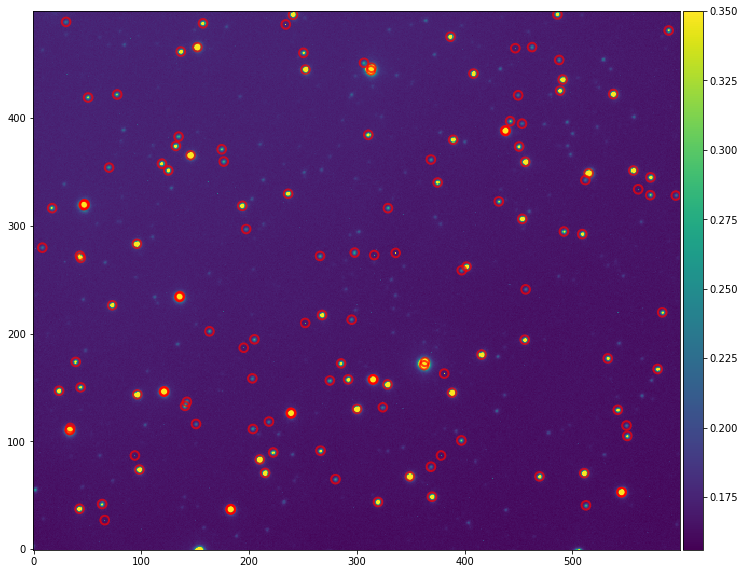

In [6]:
#%%
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from photutils import CircularAperture as CircAp

DAOfind = DAOStarFinder(fwhm=FWHM, threshold=thresh, 
                        sharplo=0.2, sharphi=3.0,  # default values: sharplo=0.2, sharphi=1.0,
                        roundlo=-1.0, roundhi=1.0,  # default values: roundlo=-1.0, roundhi=1.0,
                        sigma_radius=1.5,          # default values: sigma_radius=1.5,
                        ratio=0.9,                 # 1.0: circular gaussian:  ratio=1.0,
                        exclude_border=True)       # To exclude sources near edges : exclude_border=True

# The DAOStarFinder object ("DAOfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
DAOfound = DAOfind(img)

if len(DAOfound)==0 :
    print ('No star was founded using DAOStarFinder\n'*3)
else : 
    # Use the object "found" for aperture photometry:
    print (len(DAOfound), 'stars were founded')
    #print('DAOfound \n', DAOfound)
    DAOfound.pprint(max_width=1800)
    # save XY coordinates:
    DAOfound.write(dir_name+f_name[:-5]+'_DAOStarFinder.csv', overwrite=True, format='ascii.fast_csv')
    DAOcoord = (DAOfound['xcentroid'], DAOfound['ycentroid']) 
    
    # Save apertures as circular, 4 pixel radius, at each (X, Y)
    DAOapert = CircAp(DAOcoord, r=4.)  
    #print('DAOapert\n ', DAOapert)
    
    DAOimgXY = np.array(DAOcoord)
    #print('DAOimgXY \n', DAOimgXY)
    
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    im = plt.imshow(img, vmax=0.35, origin='lower')
    DAOapert.plot(color='red', lw=2., alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()


# IRAFStarFinder

또다른 starfinder인 IRAFStarFinder로 별이 더 잘 찾아질 수도 있다. 

이에 대한 자세한 내용 역시 [photutils documentation](https://photutils.readthedocs.io/en/stable/api/photutils.IRAFStarFinder.html#photutils.IRAFStarFinder)에 잘 요약되어 있으므로 이를 참고한다. 


124 stars founded
 id     xcentroid          ycentroid             fwhm            sharpness           roundness               pa         npix         sky                 peak                flux                mag        
--- ------------------ ------------------ ------------------ ------------------ -------------------- ------------------ ---- ------------------- ------------------- ------------------- -------------------
  1  65.96280864197531  27.04922839506173 0.8481684135871109 0.3141364494767077  0.23087308815359364 168.77204835253028    8  0.1654815673828125  0.0892181396484375      0.098876953125  2.5122623118827647
  2 181.75373314884345  37.06193421935714 1.6915355678030068 0.6264946547418544  0.10294150908180476 119.05050296074579    7  0.4694468180338542  0.3163350522518158  2.0586751997470856 -0.7839695818382824
  3 42.721714459937175  37.66848433989944 1.8263915225107958 0.6764413046336281 0.014990173434071484 119.07682094479752   11 0.26385752360026044 0.443448394536972

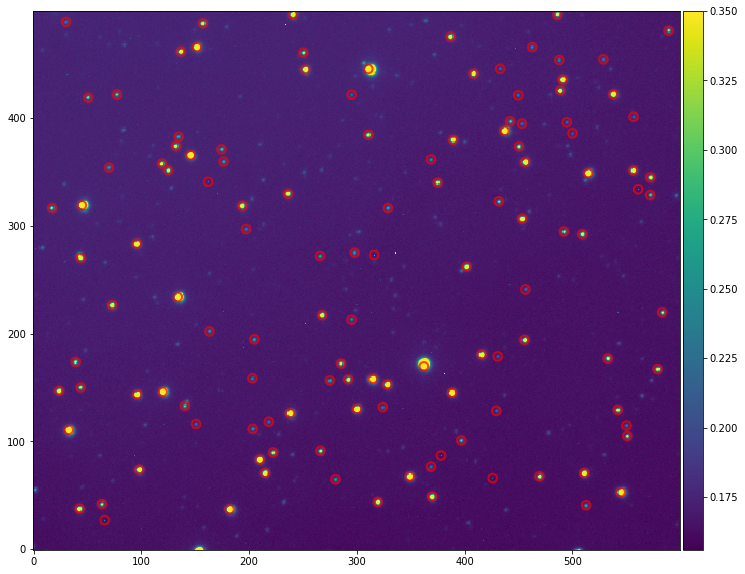

In [7]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from photutils import IRAFStarFinder
from photutils import CircularAperture as CircAp

IRAFfind = IRAFStarFinder(fwhm=FWHM, threshold=thresh,
                          sigma_radius=1.5, minsep_fwhm=2.5,  # default values: sigma_radius=1.5, minsep_fwhm=2.5,
                          sharplo=0.2, sharphi=3.0,   # default values: sharplo=0.5, sharphi=2.0,
                          roundlo=0.0, roundhi=0.5,   # default values: roundlo=0.0, roundhi=0.2,
                          sky=None, exclude_border=True)  # default values: sky=None, exclude_border=False)

# The IRAFStarFinder object ("IRAFfind") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
IRAFfound = IRAFfind(img)

if len(IRAFfound)==0 :
    print ('No star founded using IRAFStarFinder')
else : 
    # Use the object "found" for aperture photometry:
    print (len(IRAFfound), 'stars founded')
    #print('IRAFfound \n', IRAFfound)
    IRAFfound.pprint(max_width=1800)
    # save XY coordinates:
    IRAFfound.write(dir_name+f_name[:-5]+'_IRAFStarFinder.csv', overwrite=True, format='ascii.fast_csv')
    IRAFcoord = (IRAFfound['xcentroid'], IRAFfound['ycentroid']) 
    
    # Save apertures as circular, 4 pixel radius, at each (X, Y)
    IRAFapert = CircAp(IRAFcoord, r=4.)  
    #print('IRAFapert\n ', IRAFapert)
    
    IRAFimgXY = np.array(IRAFcoord)
    #print('IRAFimgXY \n', IRAFimgXY)
            
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    im = plt.imshow(img, vmax=0.35, origin='lower')
    IRAFapert.plot(color='red', lw=2., alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
